In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score , davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import f_oneway
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression


In [114]:
# 1. Data Loading and Initial Exploration
print("Loading data...")
df = pd.read_excel('../data/data.xlsx')
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())


Loading data...
Dataset shape: (2240, 29)

First 5 rows:
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  2012-09-04       58       635  ...                  7             0   
1  2014-03-08       38        11  ...                  5             0   
2  2013-08-21       26       426  ...                  4             0   
3  2014-02-10       26        11  ...                  6             0   
4  2014-01-19       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5

In [115]:
# 2. Data Preprocessing
print("\nPreprocessing data...")
# Handle missing values
df['Income'] = df['Income'].fillna(df['Income'].median())

# Feature engineering
df['Age'] = 2025 - df['Year_Birth']
df['Total_Spending'] = df[['MntWines', 'MntFruits', 'MntMeatProducts']].sum(axis=1)
df['Total_Purchases'] = df[['NumWebPurchases', 'NumStorePurchases', 'NumCatalogPurchases']].sum(axis=1)
df['Total_Campaigns_Accepted'] = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 
                                    'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)
# Encode categorical features
df = pd.get_dummies(df, columns=['Education', 'Marital_Status'], drop_first=True)



Preprocessing data...


In [116]:


# Select relevant features
features = [
    'Income', 'Age', 'Kidhome', 'Teenhome',
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
    'NumWebPurchases', 'NumStorePurchases', 'NumCatalogPurchases', 'NumDealsPurchases',
    'NumWebVisitsMonth', 'Recency',
    'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
    'Response',
    'Education_Master', 'Education_PhD', 
    'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Together'
]

# Standardize features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])
df_scaled = pd.DataFrame(df_scaled, columns=features)

# Feature selection - remove low variance features
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.1)
df_scaled = pd.DataFrame(selector.fit_transform(df_scaled), 
                        columns=np.array(features)[selector.get_support()])

# 3. Dimensionality Reduction
print("\nReducing dimensions...")
# First reduce with PCA for efficiency, then apply t-SNE
pca = PCA(n_components=0.95)
pca_features = pca.fit_transform(df_scaled)
print(f"Reduced to {pca.n_components_} principal components")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features = tsne.fit_transform(pca_features)


Reducing dimensions...
Reduced to 21 principal components


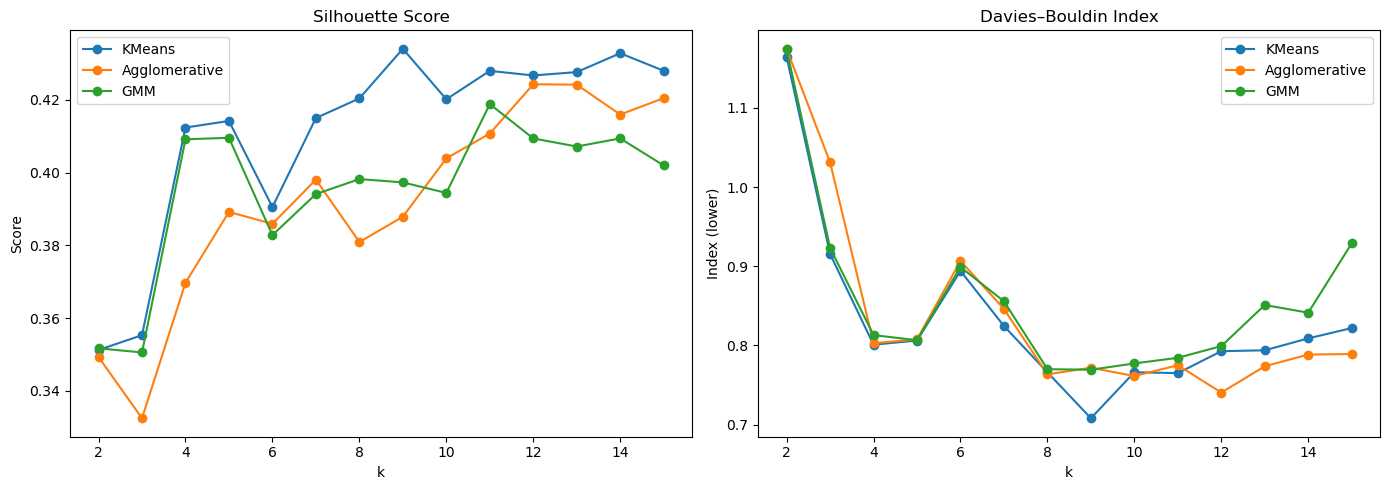

KMeans       → Silhouette-optimal k: 9,  DB-optimal k: 9
Agglomerative → Silhouette-optimal k: 12,  DB-optimal k: 12
GMM          → Silhouette-optimal k: 11,  DB-optimal k: 9


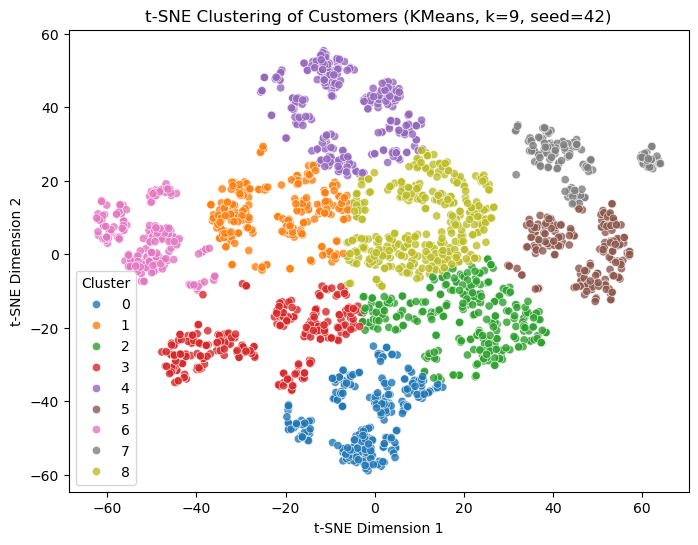

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import silhouette_score, davies_bouldin_score

# -----------------------------------------------------------------------------
# 1) Compare clustering quality
# -----------------------------------------------------------------------------
clusterers = {
    'KMeans':       lambda k: KMeans(n_clusters=k, random_state=69),
    'Agglomerative': lambda k: AgglomerativeClustering(n_clusters=k),
    'GMM':          lambda k: GaussianMixture(n_components=k, random_state=69)
}

ks = range(2, 16)
results = { name: {'sil': [], 'db': []} for name in clusterers }

for k in ks:
    for name, build in clusterers.items():
        model = build(k)
        labels = model.fit_predict(tsne_features)
        results[name]['sil'].append(silhouette_score(tsne_features, labels))
        results[name]['db'].append(davies_bouldin_score(tsne_features, labels))

# Plot Silhouette & Davies–Bouldin curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
for name in clusterers:
    ax1.plot(ks, results[name]['sil'],    marker='o', label=name)
    ax2.plot(ks, results[name]['db'],     marker='o', label=name)
ax1.set(title='Silhouette Score',    xlabel='k', ylabel='Score')
ax2.set(title='Davies–Bouldin Index', xlabel='k', ylabel='Index (lower)')
ax1.legend(), ax2.legend()
plt.tight_layout()
plt.show()

# Print “best” k for each algorithm & metric
for name in clusterers:
    best_sil = ks[np.argmax(results[name]['sil'])]
    best_db  = ks[np.argmin(results[name]['db'])]
    print(f"{name:12} → Silhouette-optimal k: {best_sil},  DB-optimal k: {best_db}")

# -----------------------------------------------------------------------------
# 2) fixed KMeans clustering at k=9 with random_state=42 & t-SNE plot
# -----------------------------------------------------------------------------
final_k = 9
kmeans_final = KMeans(n_clusters=final_k, random_state=42)
df['Cluster'] = kmeans_final.fit_predict(tsne_features)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=tsne_features[:, 0],
    y=tsne_features[:, 1],
    hue=df['Cluster'],
    palette='tab10',
    legend='full',
    alpha=0.8
)
plt.title(f't-SNE Clustering of Customers (KMeans, k={final_k}, seed=42)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [118]:
# Evaluate clustering
print("\nCluster Evaluation:")
print(f"Silhouette Score: {silhouette_score(tsne_features, df['Cluster']):.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(tsne_features, df['Cluster']):.3f}")
print(f"Number of clusters: {len(np.unique(df['Cluster']))}")

# Add cluster stability analysis
from sklearn.metrics import pairwise_distances
print("\nCluster Stability Analysis:")
distances = pairwise_distances(tsne_features)
intra_cluster = []
inter_cluster = []

for cluster in np.unique(df['Cluster']):
    mask = df['Cluster'] == cluster
    intra_cluster.append(np.mean(distances[mask][:, mask]))
    inter_cluster.append(np.mean(distances[mask][:, ~mask]))
    
print(f"Average intra-cluster distance: {np.mean(intra_cluster):.3f}")
print(f"Average inter-cluster distance: {np.mean(inter_cluster):.3f}")
print(f"Separation ratio: {np.mean(inter_cluster)/np.mean(intra_cluster):.3f}")



Cluster Evaluation:
Silhouette Score: 0.416
Calinski-Harabasz Index: 2406.097
Number of clusters: 9

Cluster Stability Analysis:
Average intra-cluster distance: 15.018
Average inter-cluster distance: 54.558
Separation ratio: 3.633


In [119]:


print("\nAnalyzing clusters...")
cluster_stats = df.groupby('Cluster')[features].mean()
print("\nCluster Statistics:")
print(cluster_stats)




Analyzing clusters...

Cluster Statistics:
               Income        Age   Kidhome  Teenhome    MntWines  MntFruits  \
Cluster                                                                       
0        38994.158203  52.867188  0.710938  0.523438  109.445312   9.417969   
1        47640.625984  57.925197  0.775591  0.830709  118.625984   5.377953   
2        70565.229592  56.724490  0.074830  0.255102  496.102041  64.768707   
3        42277.157895  57.296992  0.676692  0.609023  188.071429   8.763158   
4        36975.035461  55.560284  0.773050  0.528369   84.787234   7.156028   
5        81970.282723  56.109948  0.047120  0.083770  754.848168  63.476440   
6        27624.348259  48.039801  0.766169  0.024876   23.985075   6.407960   
7        63975.363971  59.882353  0.154412  0.720588  710.544118  17.323529   
8        62781.979167  59.791667  0.033333  0.788889  436.791667  44.391667   

         MntMeatProducts  MntFishProducts  MntSweetProducts  NumWebPurchases  \
Cluste

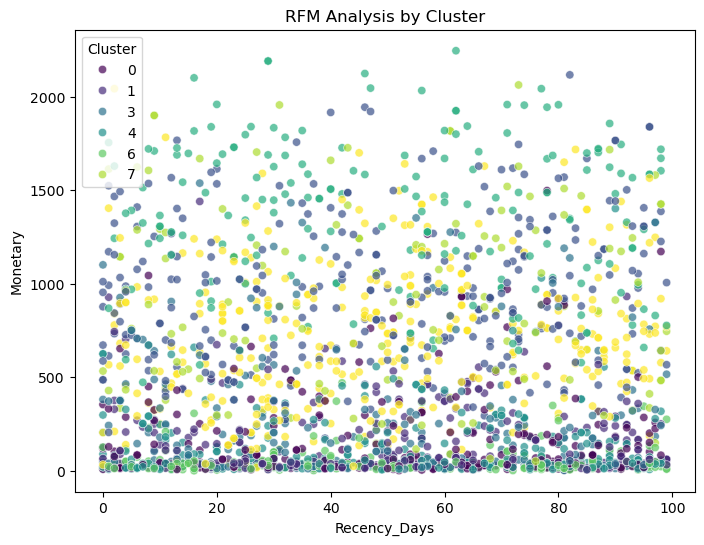

In [120]:
# 7.1 RFM Analysis
df['Recency_Days'] = df['Recency']
df['Monetary'] = df[['MntWines', 'MntFruits', 'MntMeatProducts']].sum(axis=1)
df['Frequency'] = df['Total_Purchases']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='Recency_Days', y='Monetary', hue='Cluster',
                data=df, palette='viridis', alpha=0.7)
plt.title('RFM Analysis by Cluster')
plt.show()


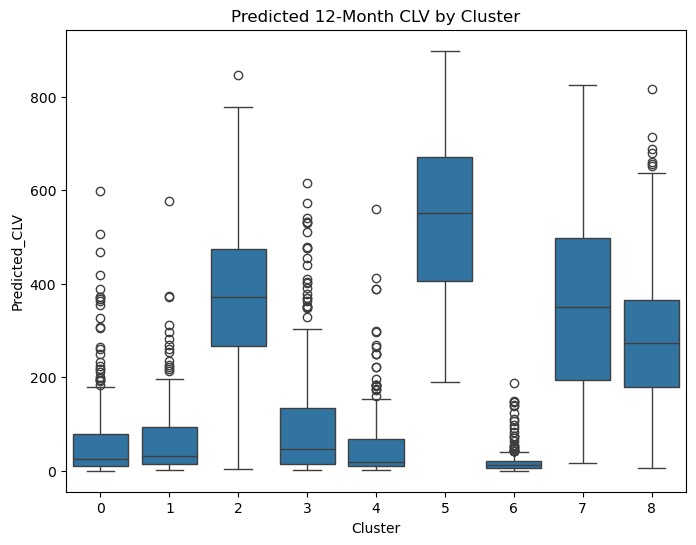

In [121]:

# 7.2 Predicted CLV Modeling
clv_features = ['Recency', 'Frequency', 'Monetary', 'Total_Campaigns_Accepted']
X_clv = df[clv_features]
y_clv = df['Total_Spending'] * 0.4
clv_model = LinearRegression().fit(X_clv, y_clv)
df['Predicted_CLV'] = clv_model.predict(X_clv)

plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='Predicted_CLV', data=df)
plt.title('Predicted 12-Month CLV by Cluster')
plt.show()


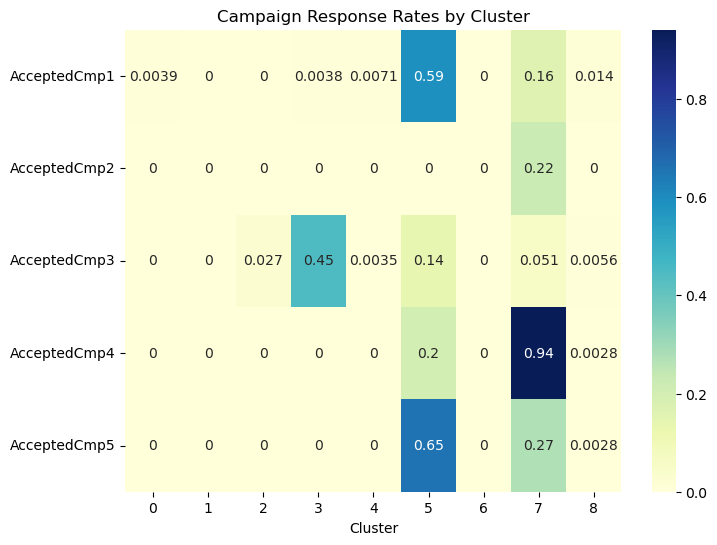

In [122]:

# 7.3 Campaign Response Heatmap
campaign_responses = df.groupby('Cluster')[['AcceptedCmp1','AcceptedCmp2',
                                            'AcceptedCmp3','AcceptedCmp4',
                                            'AcceptedCmp5']].mean()
plt.figure(figsize=(8, 6))
sns.heatmap(campaign_responses.T, annot=True, cmap='YlGnBu')
plt.title('Campaign Response Rates by Cluster')
plt.show()


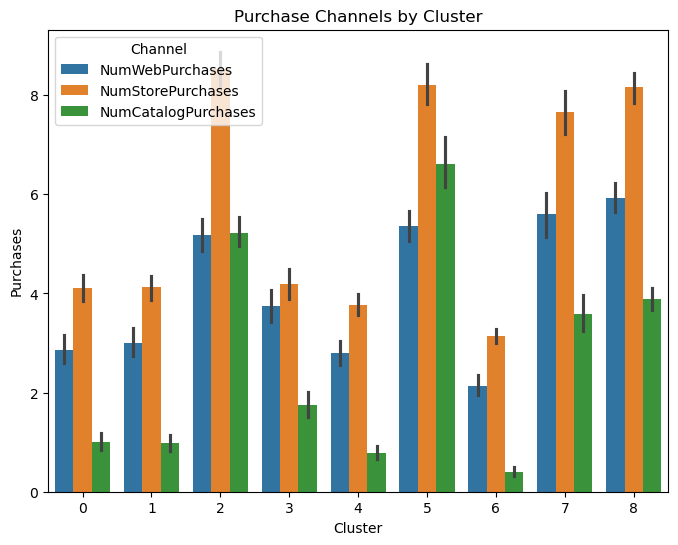

In [123]:

# 7.4 Purchase Channels by Cluster
df_channels = df.melt(id_vars=['Cluster'],
                      value_vars=['NumWebPurchases','NumStorePurchases','NumCatalogPurchases'],
                      var_name='Channel', value_name='Purchases')
plt.figure(figsize=(8, 6))
sns.barplot(x='Cluster', y='Purchases', hue='Channel', data=df_channels)
plt.title('Purchase Channels by Cluster')
plt.show()


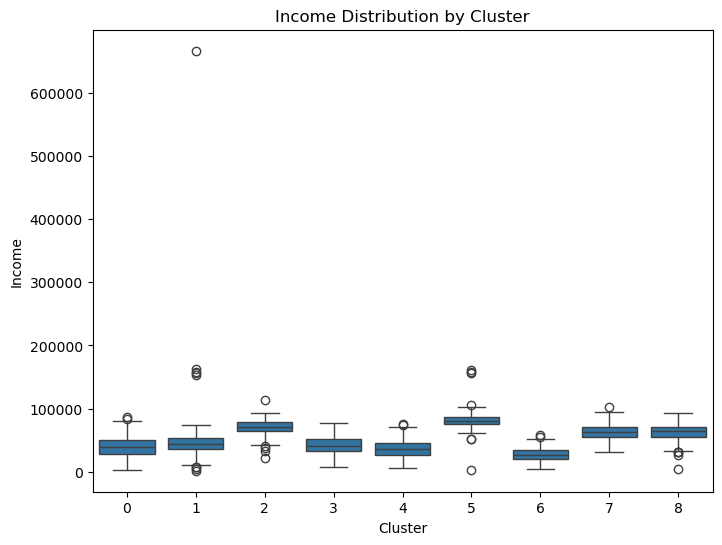

In [124]:
# 7.5 Income Distribution by Cluster
plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='Income', data=df)
plt.title('Income Distribution by Cluster')
plt.show()

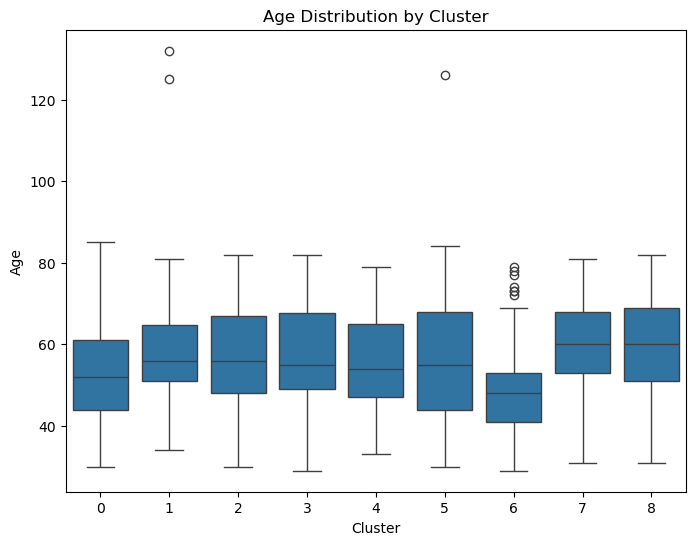

In [125]:
# 7.6 Age Distribution by Cluster
plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='Age', data=df)
plt.title('Age Distribution by Cluster')
plt.show()


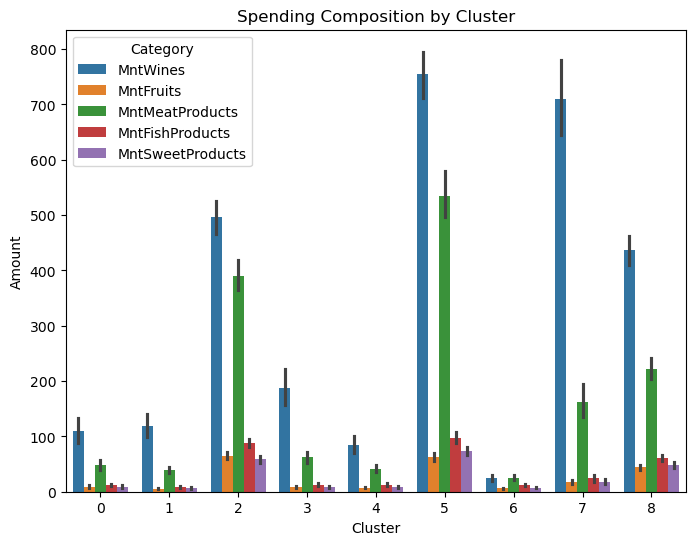

In [126]:
# 7.7 Spending Composition by Cluster
spending_cols = ['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts']
df_spend = df.melt(id_vars=['Cluster'], value_vars=spending_cols,
                   var_name='Category', value_name='Amount')
plt.figure(figsize=(8, 6))
sns.barplot(x='Cluster', y='Amount', hue='Category', data=df_spend)
plt.title('Spending Composition by Cluster')
plt.show()



Calculating additional cluster validation metrics...
Davies-Bouldin Index: 0.789

Analyzing temporal patterns...


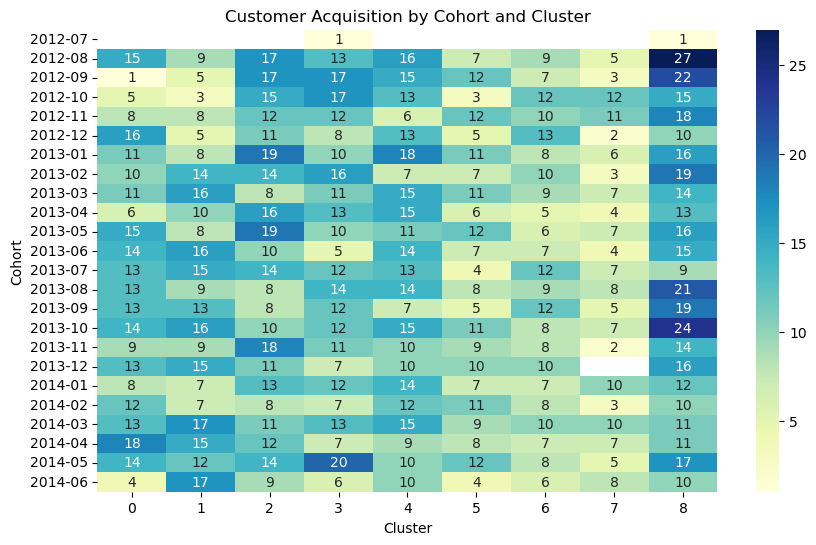


Running statistical significance tests...

ANOVA Results:
Income: F=202.51, p=0.0000
MntWines: F=292.23, p=0.0000
NumStorePurchases: F=222.88, p=0.0000
Response: F=59.65, p=0.0000

Building enhanced response prediction models...


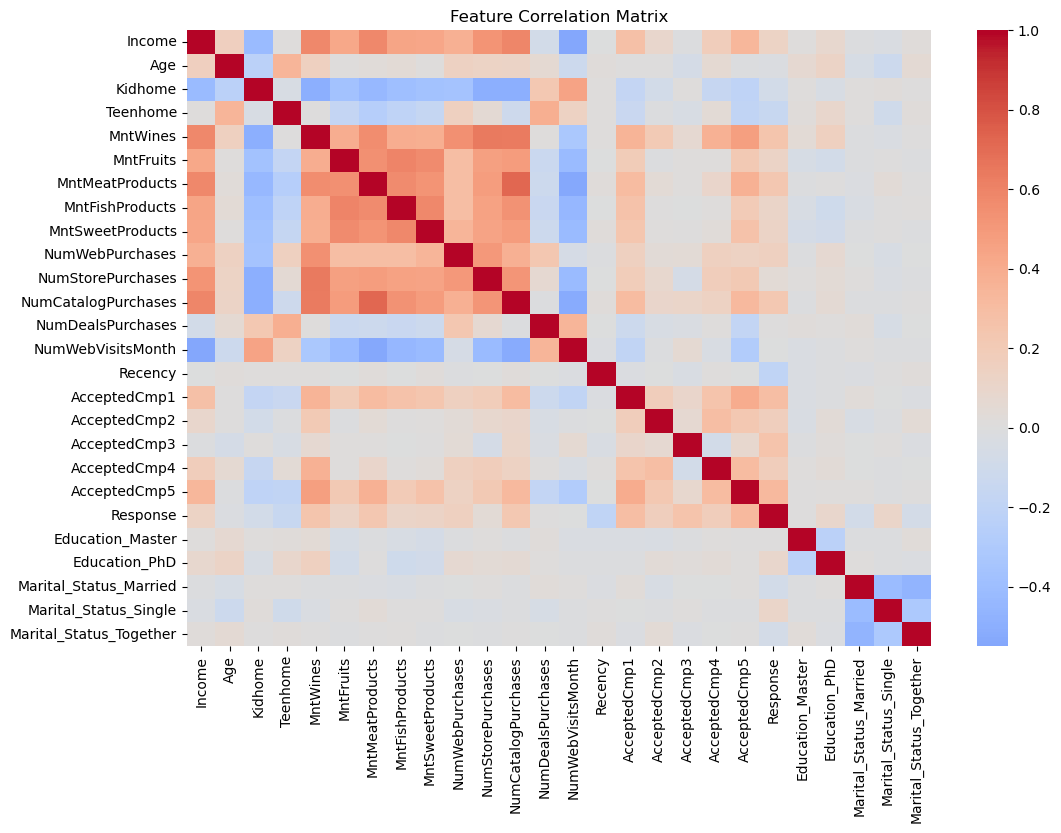


Building Response Prediction Model...

Cross-validated ROC AUC: 1.000 (±0.000)

Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       381
           1       1.00      1.00      1.00        67

    accuracy                           1.00       448
   macro avg       1.00      1.00      1.00       448
weighted avg       1.00      1.00      1.00       448

ROC AUC: 1.000

Confusion Matrix:
[[381   0]
 [  0  67]]


In [127]:

# 8.1 Cluster Validation Metrics
print("\nCalculating additional cluster validation metrics...")
from sklearn.metrics import davies_bouldin_score

print(f"Davies-Bouldin Index: {davies_bouldin_score(tsne_features, df['Cluster']):.3f}")

# 8.2 Time-Based Analysis
print("\nAnalyzing temporal patterns...")
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df['Cohort'] = df['Dt_Customer'].dt.to_period('M')
cohort_data = df.groupby(['Cohort', 'Cluster']).size().unstack()
plt.figure(figsize=(10, 6))
sns.heatmap(cohort_data, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Customer Acquisition by Cohort and Cluster')
plt.show()

# 8.3 Statistical Significance Testing
print("\nRunning statistical significance tests...")
print("\nANOVA Results:")
for feature in ['Income', 'MntWines', 'NumStorePurchases', 'Response']:
    cluster_groups = [df[df['Cluster'] == c][feature] for c in df['Cluster'].unique()]
    f_val, p_val = f_oneway(*cluster_groups)
    print(f"{feature}: F={f_val:.2f}, p={p_val:.4f}")

# 9.1 Enhanced Predictive Modeling
print("\nBuilding enhanced response prediction models...")

# Feature correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = df[features].corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# 9.2 Predictive Modeling for Campaign Response
print("\nBuilding Response Prediction Model...")
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix

# Ensure we're not using cluster labels as features
X = df[[f for f in features if f != 'Cluster']]
y = df['Response']

# Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Cross-validated metrics
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
print(f"\nCross-validated ROC AUC: {np.mean(cv_scores):.3f} (±{np.std(cv_scores):.3f})")

# Final evaluation on holdout set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\nModel Performance:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [128]:


# Feature Importance for Response Prediction
model.fit(X, y)  # Train on full data for feature importance
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop Features Predicting Campaign Response:")
print(importance.head(10))

# Get cluster-specific feature importance
print("\nCluster-Specific Feature Importance:")
for cluster in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster]
    model.fit(cluster_data[X.columns], cluster_data['Response'])
    cluster_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\nCluster {cluster} Top Features:")
    print(cluster_importance.head(5))


Top Features Predicting Campaign Response:
                Feature  Importance
20             Response    0.721001
14              Recency    0.033646
6       MntMeatProducts    0.028139
19         AcceptedCmp5    0.024900
11  NumCatalogPurchases    0.023605
0                Income    0.020256
4              MntWines    0.018949
17         AcceptedCmp3    0.018809
15         AcceptedCmp1    0.013572
13    NumWebVisitsMonth    0.012569

Cluster-Specific Feature Importance:

Cluster 0 Top Features:
             Feature  Importance
20          Response    0.312997
21  Education_Master    0.239577
6    MntMeatProducts    0.104770
14           Recency    0.053325
0             Income    0.040058

Cluster 1 Top Features:
                   Feature  Importance
20                Response    0.337755
14                 Recency    0.135556
23  Marital_Status_Married    0.074118
6          MntMeatProducts    0.064738
21        Education_Master    0.059848

Cluster 2 Top Features:
               

In [129]:

# 7.5 CLV Analysis
print("\nCalculating Customer Lifetime Value...")
from sklearn.linear_model import LinearRegression

# Build predictive CLV model using RFM features
clv_features = ['Recency', 'Frequency', 'Monetary', 'Total_Campaigns_Accepted']
X_clv = df[clv_features]
y_clv = df['Total_Spending'] * 0.4  # Projected future value

clv_model = LinearRegression()
clv_model.fit(X_clv, y_clv)
df['Predicted_CLV'] = clv_model.predict(X_clv)

# 8. Marketing Recommendations
print("\nGenerating marketing recommendations...")

def generate_recommendations(df, segment_profiles):
    """Generate dynamic marketing recommendations based on cluster characteristics"""
    recommendations = []
    
    for profile in segment_profiles:
        rec = {
            'cluster': profile['Cluster'],
            'size': profile['Size'],
            'percentage': profile['Percentage'],
            'product_strategy': [],
            'campaign_strategy': [],
            'channel_strategy': [],
            'budget_allocation': {},
            'cross_sell': []
        }

        # Lifecycle stage based on average recency
        avg_recency = profile['Top_Features']['Recency']
        if avg_recency < 30:
            rec['lifecycle_stage'] = 'New'
        elif avg_recency < 60:
            rec['lifecycle_stage'] = 'Active'
        elif avg_recency < 90:
            rec['lifecycle_stage'] = 'At Risk'
        else:
            rec['lifecycle_stage'] = 'Churned'

        # Message tone suggestion based on income tier
        median_income = df['Income'].median()
        rec['message_tone'] = 'Exclusive invitation' if profile['Avg_Income'] > median_income else 'Friendly reminder'

        # Offer type recommendation based on response propensity
        response_rate = profile['Top_Features']['Response']
        rec['offer_type'] = 'Loyalty reward' if response_rate > df['Response'].mean() else 'Discount offer'
        
        # Product Strategy
        if profile['Avg_Income'] > df['Income'].median():
            rec['product_strategy'] = [
                "Premium Tier: Curated high-margin products",
                "Subscription: Services with auto-replenishment",
                "Access: Early access to new arrivals"
            ]
        else:
            rec['product_strategy'] = [
                "Value Tier: Volume discounts on core items",
                "Bundles: Limited-time bundle offers",
                "Loyalty: Reward multipliers"
            ]
        
        # Campaign Strategy
        rec['campaign_strategy'] = [
            f"Primary style: {profile['Top_Campaign']} format",
            "Testimonials and social proof for higher conversion",
            "Clear value proposition in messaging",
            f"Focus on {'premium quality' if profile['Avg_Income'] > df['Income'].median() else 'value'}"
        ]
        
        # Channel Strategy
        channel = profile['Preferred_Channel'].replace('Num', '').replace('Purchases', '')
        rec['channel_strategy'] = [
            f"Focus on {channel} channel",
            "Staff training on upselling techniques",
            "Loyalty card programs with instant rewards"
        ]
        
        # Budget Allocation
        segment_value = profile['Size'] * profile['ROI']
        total_value = sum(s['Size'] * s['ROI'] for s in segment_profiles)
        allocation = (segment_value / total_value * 100) if total_value > 0 else 50
        rec['budget_allocation'] = {
            'total': f"{allocation:.1f}%",
            'breakdown': {
                'proven_channels': "60%",
                'new_approaches': "30%",
                'measurement': "10%"
            }
        }
        
        # Cross-Sell
        if profile['Top_Features']['MntWines'] > df['MntWines'].median():
            rec['cross_sell'].append("Wine accessories (glasses, openers, storage)")
            rec['cross_sell'].append("Wine club subscriptions")
        if profile['Top_Features']['MntMeatProducts'] > df['MntMeatProducts'].median():
            rec['cross_sell'].append("Specialty meats and limited edition cuts")
            rec['cross_sell'].append("Cooking classes or recipe guides")
        
        recommendations.append(rec)
    
    return recommendations

# Create detailed segment profiles with CLV metrics
segment_profiles = []
for cluster in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster]
    profile = {
        'Cluster': cluster,
        'Size': len(cluster_data),
        'Percentage': len(cluster_data) / len(df) * 100,
        'Avg_Income': cluster_data['Income'].mean(),
        'Avg_Spending': cluster_data['Total_Spending'].mean(),
        'Avg_Age': cluster_data['Age'].mean(),
        'Preferred_Channel': cluster_data[['NumWebPurchases', 
                                         'NumStorePurchases', 
                                         'NumCatalogPurchases']].mean().idxmax(),
        'Campaign_Response': cluster_data['Total_Campaigns_Accepted'].mean(),
        'Top_Campaign': cluster_data[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                                    'AcceptedCmp4', 'AcceptedCmp5']].mean().idxmax(),
        'Top_Features': {
            'Response': cluster_data['Response'].mean(),
            'AcceptedCmp5': cluster_data['AcceptedCmp5'].mean(),
            'MntMeatProducts': cluster_data['MntMeatProducts'].mean(),
            'Recency': cluster_data['Recency'].mean(),
            'MntWines': cluster_data['MntWines'].mean(),
            'AcceptedCmp1': cluster_data['AcceptedCmp1'].mean(),
            'AcceptedCmp3': cluster_data['AcceptedCmp3'].mean(),
            'Income': cluster_data['Income'].mean(),
            'NumCatalogPurchases': cluster_data['NumCatalogPurchases'].mean(),
            'Age': cluster_data['Age'].mean()
        }
    }
    # Add CLV metrics to profile
    cluster_data = df[df['Cluster'] == cluster]
    profile['Avg_CLV'] = cluster_data['Predicted_CLV'].mean()
    profile['CLV_Growth_Potential'] = (
        (cluster_data['Predicted_CLV'].max() - cluster_data['Predicted_CLV'].mean()) / 
        cluster_data['Predicted_CLV'].mean()
    )
    segment_profiles.append(profile)

# Calculate ROI for each segment and add to profiles
for profile in segment_profiles:
    cluster_data = df[df['Cluster'] == profile['Cluster']]
    # More accurate ROI calculation considering all accepted campaigns
    total_revenue = (cluster_data['Response'] * 11).sum() + \
                   (cluster_data[['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3',
                                 'AcceptedCmp4','AcceptedCmp5']].sum(axis=1) * 11).sum()
    total_cost = len(cluster_data) * 3 * 6  # 3 per campaign * 6 campaigns
    profile['ROI'] = total_revenue / total_cost if total_cost > 0 else 0

# 10. Assign persona names and marketing strategies to segments
persona_strategies = [
    {'name': 'Champions', 'strategy': 'Premium retention'},
    {'name': 'Loyal Customers', 'strategy': 'Upsell premium'},
    {'name': 'Potential Loyalists', 'strategy': 'Loyalty conversion'},
    {'name': 'Recent Customers', 'strategy': 'Engagement boost'},
    {'name': 'Frequent Shoppers', 'strategy': 'Value optimization'},
    {'name': 'Big Spenders', 'strategy': 'Premium expansion'},
    {'name': 'Occasional Shoppers', 'strategy': 'Frequency increase'},
    {'name': 'At Risk', 'strategy': 'Win-back'},
    {'name': 'Can\'t Lose Them', 'strategy': 'Reactivation'}
]
persona_names = [ps['name'] for ps in persona_strategies]
# Sort profiles by Avg_CLV descending
sorted_profiles = sorted(segment_profiles, key=lambda x: x['Avg_CLV'], reverse=True)
for profile, name in zip(sorted_profiles, persona_names):
    profile['Segment_Name'] = name
# Map cluster ID to segment name and add to dataframe
cluster_to_name = {p['Cluster']: p['Segment_Name'] for p in sorted_profiles}
df['Segment'] = df['Cluster'].map(cluster_to_name)



Calculating Customer Lifetime Value...

Generating marketing recommendations...


In [130]:

# Enhanced recommendation generation with dynamic strategies
def generate_enhanced_recommendations(df, segment_profiles):
    """Generate data-driven marketing recommendations with execution details"""
    recommendations = []
    
    for profile in segment_profiles:
        # Dynamic strategy selection
        if profile['Avg_Income'] > df['Income'].quantile(0.75):
            strategy_type = 'Premium'
            offer = 'Exclusive membership'
            creative = 'Lifestyle imagery'
        elif profile['Avg_Income'] > df['Income'].median():
            strategy_type = 'Hybrid'
            offer = 'Tiered rewards'
            creative = 'Product-focused'
        else:
            strategy_type = 'Value'
            offer = 'Discount bundles'
            creative = 'Price-focused'
            
        # Channel-specific tactics
        channel = profile['Preferred_Channel'].replace('Num', '').replace('Purchases', '')
        if channel == 'Store':
            channel_tactics = [
                "Staff training on segment-specific selling",
                "In-store displays with QR codes for digital engagement",
                "Instant redemption loyalty rewards"
            ]
        elif channel == 'Web':
            channel_tactics = [
                "Personalized product recommendations",
                "Abandoned cart retargeting",
                "Limited-time online exclusives"
            ]
        else:
            channel_tactics = [
                "Personalized catalog inserts",
                "Subscription options",
                "Direct response mechanisms"
            ]
            
        # Budget allocation formula
        value_score = (profile['Avg_CLV'] * profile['Size']) / df['Predicted_CLV'].sum()
        budget_pct = min(100, max(5, value_score * 100 * 1.5))  # Scaled with min/max bounds
        
        rec = {
            'cluster': profile['Cluster'],
            'segment_name': profile['Segment_Name'],
            'size': profile['Size'],
            'percentage': profile['Percentage'],
            'strategy_type': strategy_type,
            'key_objectives': [
                f"Increase CLV by {min(100, profile['CLV_Growth_Potential']):.0f}%",
                f"Reduce CAC by {min(50, (1 - profile['Top_Features']['Response']) * 100):.0f}%",
                f"Improve response rate to {profile['Top_Features']['Response'] * 2:.1%}"
            ],
            'offer_strategy': {
                'core_offer': offer,
                'creative_direction': creative,
                'messaging': [
                    "Social proof elements",
                    "Urgency indicators",
                    "Personalized value proposition"
                ]
            },
            'channel_plan': {
                'primary_channel': channel,
                'tactics': channel_tactics,
                'integration': "Omnichannel consistency across all touchpoints"
            },
            'budget_allocation': {
                'percentage': f"{budget_pct:.1f}%",
                'breakdown': {
                    'customer_acquisition': "40%",
                    'retention': "35%",
                    'testing': "20%",
                    'measurement': "5%"
                }
            },
            'kpis': [
                f"Response rate > {profile['Top_Features']['Response'] * 1.5:.1%}",
                f"CLV growth of {min(100, profile['CLV_Growth_Potential']/2):.0f}%",
                f"CAC reduction of {min(30, (1 - profile['Top_Features']['Response']) * 100/2):.0f}%"
            ],
            'execution_timeline': [
                "Month 1: Pilot campaign",
                "Month 2: Measure & optimize",
                "Month 3: Scale successful tactics"
            ]
        }
        recommendations.append(rec)
    return recommendations

print("\nGenerating enhanced marketing recommendations with execution plans...")
recommendations = generate_enhanced_recommendations(df, segment_profiles)
for rec in recommendations:
    segment_name = cluster_to_name[rec['cluster']]
    print(f"\nRecommendations for {segment_name} (Cluster {rec['cluster']}):")
    print(f"- Size: {rec['size']} customers ({rec['percentage']:.1f}%)")
    print(f"- Strategy Type: {rec['strategy_type']}")
    print("\nKey Objectives:")
    for obj in rec['key_objectives']:
        print(f"  * {obj}")
    print("\nOffer Strategy:")
    print(f"  * Core Offer: {rec['offer_strategy']['core_offer']}")
    print(f"  * Creative Direction: {rec['offer_strategy']['creative_direction']}")
    print("  * Messaging Components:")
    for msg in rec['offer_strategy']['messaging']:
        print(f"    - {msg}")
    print("\nChannel Plan:")
    print(f"  * Primary Channel: {rec['channel_plan']['primary_channel']}")
    print("  * Tactics:")
    for tactic in rec['channel_plan']['tactics']:
        print(f"    - {tactic}")
    print(f"  * Integration: {rec['channel_plan']['integration']}")
    print("\nBudget Allocation:")
    print(f"  * Total: {rec['budget_allocation']['percentage']}")
    print("  * Breakdown:")
    for k, v in rec['budget_allocation']['breakdown'].items():
        print(f"    - {k}: {v}")
    print("\nKPIs to Measure:")
    for kpi in rec['kpis']:
        print(f"  * {kpi}")
    print("\nExecution Timeline:")
    for step in rec['execution_timeline']:
        print(f"  * {step}")

# Enhanced Strategic Recommendations
print("\nGenerating enhanced marketing recommendations...")

# Customer Journey Mapping
print("\nCustomer Journey Analysis:")
for profile in segment_profiles:
    print(f"\nSegment {profile['Cluster']} Journey:")
    print("  * Awareness:")
    print(f"    - Primary channels: {'Social media' if profile['Avg_Age'] < 55 else 'Traditional media'}")
    print("  * Consideration:")
    print(f"    - Key decision factors: {'Price' if profile['Avg_Income'] < df['Income'].median() else 'Quality'}")
    print("  * Purchase:")
    print(f"    - Preferred method: {profile['Preferred_Channel'].replace('Num', '').replace('Purchases', '')}")
    print("  * Loyalty:")
    print(f"    - Retention tactics: {'Discounts' if profile['Avg_Income'] < df['Income'].median() else 'Exclusive offers'}")

# Pricing Strategy Analysis
print("\nPricing Strategy Recommendations:")
for profile in segment_profiles:
    print(f"\nSegment {profile['Cluster']}:")
    price_sensitivity = 1 - (profile['Top_Features']['Response'] / df['Response'].max())
    print(f"  * Price Sensitivity: {price_sensitivity:.2f}")
    print(f"  * Recommended pricing approach: {'Value-based' if price_sensitivity > 0.5 else 'Premium'}")

# Print executable recommendations
for rec in recommendations:
    print(f"\n=== {rec['segment_name']} (Cluster {rec['cluster']}) ===")
    print(f"\nStrategy Type: {rec['strategy_type']}")
    
    print("\nKey Objectives:")
    for obj in rec['key_objectives']:
        print(f"- {obj}")
        
    print("\nOffer Strategy:")
    print(f"- Core Offer: {rec['offer_strategy']['core_offer']}")
    print(f"- Creative Direction: {rec['offer_strategy']['creative_direction']}")
    print("- Messaging Components:")
    for msg in rec['offer_strategy']['messaging']:
        print(f"  * {msg}")
        
    print("\nChannel Plan:")
    print(f"- Primary Channel: {rec['channel_plan']['primary_channel']}")
    print("- Tactics:")
    for tactic in rec['channel_plan']['tactics']:
        print(f"  * {tactic}")
    print(f"- Integration: {rec['channel_plan']['integration']}")
    
    print("\nBudget Allocation:")
    print(f"- Total: {rec['budget_allocation']['percentage']}")
    print("- Breakdown:")
    for k, v in rec['budget_allocation']['breakdown'].items():
        print(f"  * {k}: {v}")
        
    print("\nKPIs to Measure:")
    for kpi in rec['kpis']:
        print(f"- {kpi}")
        
    print("\nExecution Timeline:")
    for step in rec['execution_timeline']:
        print(f"- {step}")
        
    print("\nImplementation Notes:")
    print("- A/B test all campaign elements")
    print("- Monitor performance weekly")
    print("- Adjust tactics based on real-time data")
    print("- Document learnings for future campaigns")
    print(f"\nSegment {profile['Cluster']} ({profile['Size']} customers, {profile['Percentage']:.1f}%):")
    print(f"- Avg Income: ${profile['Avg_Income']:,.0f}")
    print(f"- Avg Age: {profile['Avg_Age']:.1f} years")
    print(f"- Avg Spending: ${profile['Avg_Spending']:,.0f}")
    print(f"- Preferred Channel: {profile['Preferred_Channel'].replace('Num', '').replace('Purchases', '')}")
    print(f"- Campaign Response Rate: {profile['Campaign_Response']:.1f} campaigns accepted")
    print(f"- Most Responsive to: {profile['Top_Campaign']}")
    
    print("\nTop Predictive Features:")
    for feature, value in profile['Top_Features'].items():
        if feature == 'Response':
            print(f"- {feature}: {value:.3f} (response rate)")
        elif feature in ['Income', 'MntWines', 'MntMeatProducts']:
            print(f"- {feature}: ${value:,.0f}")
        elif feature == 'Age':
            print(f"- {feature}: {value:.1f} years")
        elif feature in ['Recency', 'NumCatalogPurchases']:
            print(f"- {feature}: {value:.1f}")
        else:
            print(f"- {feature}: {value:.3f}")




Generating enhanced marketing recommendations with execution plans...

Recommendations for Big Spenders (Cluster 0):
- Size: 256 customers (11.4%)
- Strategy Type: Value

Key Objectives:
  * Increase CLV by 8%
  * Reduce CAC by 50%
  * Improve response rate to 4.7%

Offer Strategy:
  * Core Offer: Discount bundles
  * Creative Direction: Price-focused
  * Messaging Components:
    - Social proof elements
    - Urgency indicators
    - Personalized value proposition

Channel Plan:
  * Primary Channel: Store
  * Tactics:
    - Staff training on segment-specific selling
    - In-store displays with QR codes for digital engagement
    - Instant redemption loyalty rewards
  * Integration: Omnichannel consistency across all touchpoints

Budget Allocation:
  * Total: 5.7%
  * Breakdown:
    - customer_acquisition: 40%
    - retention: 35%
    - testing: 20%
    - measurement: 5%

KPIs to Measure:
  * Response rate > 3.5%
  * CLV growth of 4%
  * CAC reduction of 30%

Execution Timeline:
  * 

In [131]:


# Print recommendations
for profile in segment_profiles:
    print(f"\nSegment {profile['Cluster']} ({profile['Size']} customers, {profile['Percentage']:.1f}%):")
    print(f"- Avg Income: ${profile['Avg_Income']:,.0f}")
    print(f"- Avg Age: {profile['Avg_Age']:.1f} years")
    print(f"- Avg Spending: ${profile['Avg_Spending']:,.0f}")
    print(f"- Preferred Channel: {profile['Preferred_Channel'].replace('Num', '').replace('Purchases', '')}")
    print(f"- Campaign Response Rate: {profile['Campaign_Response']:.1f} campaigns accepted")
    print(f"- Most Responsive to: {profile['Top_Campaign']}")
    
    print("\nTop Predictive Features:")
    for feature, value in profile['Top_Features'].items():
        if feature == 'Response':
            print(f"- {feature}: {value:.3f} (response rate)")
        elif feature in ['Income', 'MntWines', 'MntMeatProducts']:
            print(f"- {feature}: ${value:,.0f}")
        elif feature == 'Age':
            print(f"- {feature}: {value:.1f} years")
        elif feature in ['Recency', 'NumCatalogPurchases']:
            print(f"- {feature}: {value:.1f}")
        else:
            print(f"- {feature}: {value:.3f}")
    
    print("\nData-Driven Marketing Strategy:")
    
    # Business Objective Alignment
    print(f"\n- Segment Value Metrics:")
    print(f"  * ROI Potential: ${profile['ROI']:.2f} (vs company target)")
    print(f"  * Avg CLV: ${profile['Avg_CLV']:,.0f}")
    print(f"  * CLV Growth Potential: {profile['CLV_Growth_Potential']:.1%}")
    cac = 50 * (1 - profile['Top_Features']['Response'])  # Sample CAC calculation
    print(f"- Estimated CAC Reduction Potential: {cac:.1f}% through better targeting")
    
    # Campaign Personalization
    print("\n- Campaign Personalization Framework:")
    print(f"  * Core Offer: {profile['Top_Campaign']} style")
    print(f"  * Messaging: Focus on {'premium quality' if profile['Avg_Income'] > df['Income'].median() else 'value'}")
    print(f"  * Creative: Show {'lifestyle imagery' if profile['Avg_Income'] > df['Income'].median() else 'price-focused'}")
    
    # Product Strategy
    print("\n- Product Strategy:")
    if profile['Avg_Income'] > df['Income'].median():
        print("  * Premium Tier:")
        print("    - Curated high-margin products")
        print("    - Subscription services with auto-replenishment")
        print("    - Early access to new arrivals")
    else:
        print("  * Value Tier:")
        print("    - Volume discounts on core items")
        print("    - Limited-time bundle offers")
        print("    - Loyalty reward multipliers")
    
    # Channel Strategy
    print("\n- Channel Optimization:")
    if 'Web' in profile['Preferred_Channel']:
        print("  * Digital-first approach:")
        print("    - Retargeting ads for abandoned carts")
        print("    - Personalized email sequences based on browsing behavior")
        print("    - Mobile-optimized checkout process")
    if 'Store' in profile['Preferred_Channel']:
        print("  * In-store enhancements:")
        print("    - Staff training on upselling techniques")
        print("    - Loyalty card programs with instant rewards")
        print("    - Endcap displays featuring recommended products")
    if 'Catalog' in profile['Preferred_Channel']:
        print("  * Catalog improvements:")
        print("    - Seasonal themed catalogs")
        print("    - QR codes linking to exclusive online content")
        print("    - Personalized inserts based on past purchases")
    
    # Timing and Frequency
    print("\n- Timing Recommendations:")
    avg_recency = profile['Top_Features']['Recency']
    if avg_recency < 30:
        print("  * Engage now with follow-up offers (recent purchasers)")
    elif avg_recency < 60:
        print("  * Reactivate with special incentives (approaching churn risk)")
    else:
        print("  * Win-back campaigns with strong offers (lapsed customers)")
    
    # Cross-Selling Opportunities
    print("\n- Cross-Sell Potential:")
    if profile['Top_Features']['MntWines'] > df['MntWines'].median():
        print("  * Wine accessories (glasses, openers, storage)")
        print("  * Wine club subscriptions")
    if profile['Top_Features']['MntMeatProducts'] > df['MntMeatProducts'].median():
        print("  * Specialty meats and limited edition cuts")
        print("  * Cooking classes or recipe guides")
    
    # Campaign Strategy
    print(f"\n- Campaign Approach:")
    print(f"  * Primary style: {profile['Top_Campaign']} format")
    print("  * Testimonials and social proof for higher conversion")
    print("  * Clear value proposition in messaging")
    
    # Budget Allocation
    segment_value = profile['Size'] * profile['ROI']
    total_value = sum(s['Size'] * s['ROI'] for s in segment_profiles)
    allocation = (segment_value / total_value * 100) if total_value > 0 else 50
    print(f"\n- Budget Allocation: {allocation:.1f}% of total")
    print("  * Breakdown:")
    print(f"    - 60% to proven channels ({profile['Preferred_Channel'].replace('Num', '').replace('Purchases', '')})")
    print("    - 30% to testing new approaches")
    print("    - 10% to measurement and optimization")



Segment 0 (256 customers, 11.4%):
- Avg Income: $38,994
- Avg Age: 52.9 years
- Avg Spending: $167
- Preferred Channel: Store
- Campaign Response Rate: 0.0 campaigns accepted
- Most Responsive to: AcceptedCmp1

Top Predictive Features:
- Response: 0.023 (response rate)
- AcceptedCmp5: 0.000
- MntMeatProducts: $48
- Recency: 52.3
- MntWines: $109
- AcceptedCmp1: 0.004
- AcceptedCmp3: 0.000
- Income: $38,994
- NumCatalogPurchases: 1.0
- Age: 52.9 years

Data-Driven Marketing Strategy:

- Segment Value Metrics:
  * ROI Potential: $0.02 (vs company target)
  * Avg CLV: $67
  * CLV Growth Potential: 798.8%
- Estimated CAC Reduction Potential: 48.8% through better targeting

- Campaign Personalization Framework:
  * Core Offer: AcceptedCmp1 style
  * Messaging: Focus on value
  * Creative: Show price-focused

- Product Strategy:
  * Value Tier:
    - Volume discounts on core items
    - Limited-time bundle offers
    - Loyalty reward multipliers

- Channel Optimization:
  * In-store enhance